# Online Payments Fraud Detection

This project goals are:

- Provide an analysis on the data.
- Create a model based on classification to detect fraudulent payments.
- Use hypotetical testing to check for reliable results from models.

Online payment frauds are one of the main risks of e-Commerce, in 2021, $ 20 billions were estimated to be lost by fraudulent transactions according to [Juniper research](https://www.juniperresearch.com/infographics/online-payment-fraud-statistics). Also according to [Juniper](https://www.juniperresearch.com/infographics/online-payment-fraud-statistics), most of the frauds are US based, with a rapid growth of frauds in China. This is due to mainly three points, the pandemic forced stores to move to e-Commerce which have frauds they are not prepared for, data breaches and fraudsters using machine learning to enhance the practice.

According to [Merchant Savvy](https://www.merchantsavvy.co.uk/payment-fraud-statistics/), companies that invest in a fraud detection program have reduced attack response expenses by 42%, reduced by 17% the investment in prevention, also reducing by 16% the amount of fines/penalties payed with such a program. In South America alone, according to [MRC](https://www.ravelin.com/insights/online-payment-fraud), 2.8% of suspected transactions were saved by having proper sistems in place.

The dataset used for this study is available on Kaggle, you can check it [here](https://www.kaggle.com/datasets/ealaxi/paysim1), it is composed by artificial data sourced from the [PaySim](https://github.com/EdgarLopezPhD/PaySim), a mobile money payment simulator.

## Downloading the dataset

First, let's download the dataset into the directory the notebook is running.

The dataset is composed by only one csv file, which can be done easily with the following code.

**WARNING**

Don't forget to generate a API key with your Kaggle account, this process can be done by accessing your profile on the "Account" tab, you will generate a .json file with your account name and key, that should be provided in order to download the dataset through this method.

In [1]:
# Run this cell in case you don't have the required packages
%pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import opendatasets as ods

In [3]:
ods.download("https://www.kaggle.com/datasets/ealaxi/paysim1")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: romulopeixoto
Your Kaggle Key: ··········


100%|██████████| 178M/178M [00:05<00:00, 31.7MB/s]


## Exploratory Data Analysis

Now that the dataset is downloaded, let's start understanding the data a litte better.

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize, PowerTransformer
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [31]:
data = pd.read_csv("paysim1/PS_20174392719_1491204439457_log.csv")

In [6]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [8]:
data.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

After this first commands, is possible to conclude that is a large number of observations and that not a single row has a empty value.

Another conclusion is that "nameOrig" and "nameDest" is a mixed type of value, maybe splitting information can give us some useful gain.

But first let's analyze the numerical features.

In [9]:
data_skew = data.skew(axis = 0)
data_kurt = data.kurt(axis = 0)
data_median = data.median()
data.describe().T.assign(skewness = data_skew, kurtosis = data_kurt, median = data_median)

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis,median
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02,0.375177,0.329071,239.000
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07,30.993949,1797.956705,74871.940
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07,5.249136,32.964879,14208.000
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07,5.176884,32.066985,0.000
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08,19.921758,948.674125,132705.665
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08,19.352302,862.156508,214661.440
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00,27.779538,769.702982,0.000
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00,630.603629,397659.062500,0.000


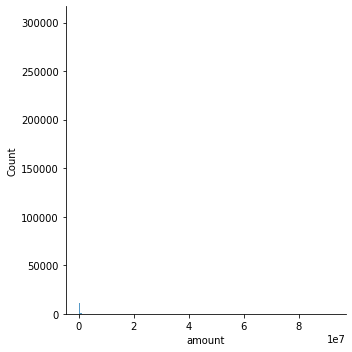

In [36]:
# mexer no facetgrid
sns.displot(data["amount"])

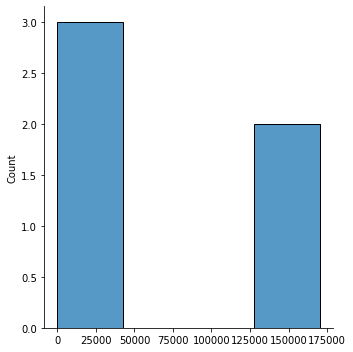

In [35]:
sns.displot(num_data[0:-1][0])

Here is possible to see how spread the data is, the "step" feature is a measure of time, it will be transformed later into a something workable, "isFraud" and "isFlaggedFraud" are both categorical, despite that encoded already.

The other features are truelly numerical and have a very unique shape, let's visualize them.

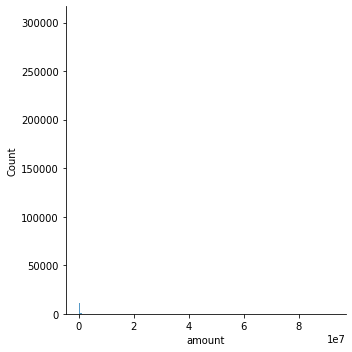

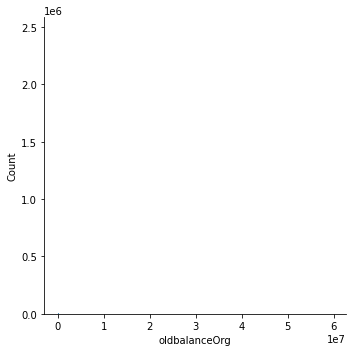

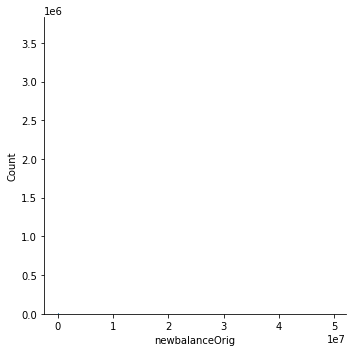

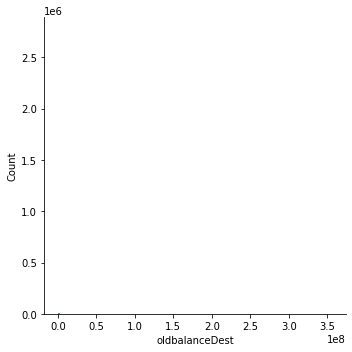

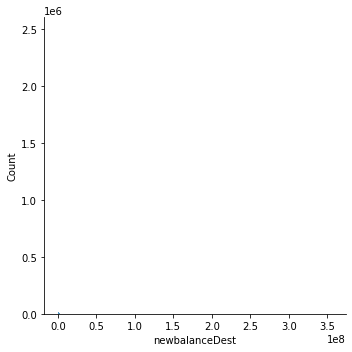

In [28]:
for column in ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]:
    sns.displot(data[column]);
    plt.show()

This result shows that data is highly uneven and require some treatment to be ready to be implmented on a model, since this dataset require a classification kind of algorithm, it's important to data to be scaled properly due to information gain.

The solution for this kind of problem is that the shape of the distribuition requires change, not only to be rescaled, since there are a number of rescaling techniques, here will be compared only three, Normalization, Logarithm transformation and  Box Cox. This is a technique that will be tested in order to use a more wide range of classification algorithms.

In [34]:
num_data = np.array(data[["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]])

In [12]:
np.where(num_data < 0)

(array([], dtype=int64), array([], dtype=int64))

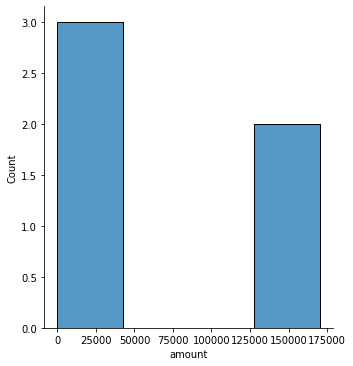

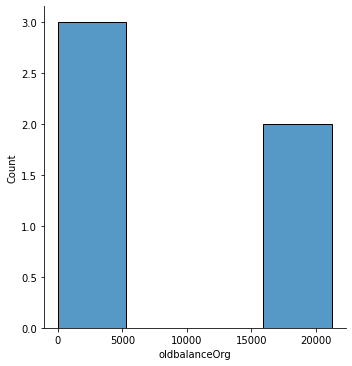

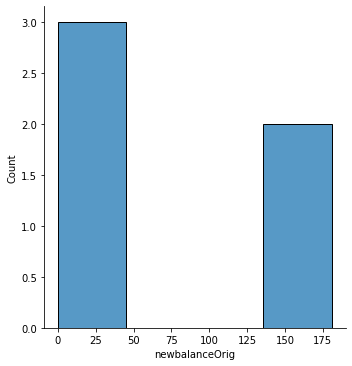

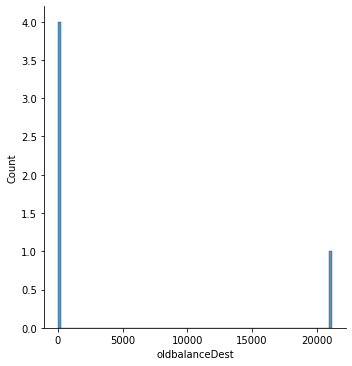

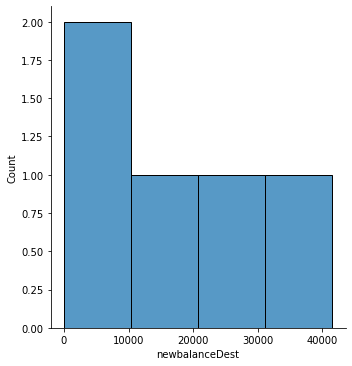

In [29]:
i = 0
columns = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
for column in columns:
  if i < len(columns):
    sns.displot(num_data[i]);
    plt.xlabel(xlabel = columns[i])
    plt.show()
    i += 1

In [15]:
# Normalized data
norm_num_data = normalize(num_data)

In [16]:
norm_num_data

array([[0.04205666, 0.72719646, 0.6851398 , 0.        , 0.        ],
       [0.06468038, 0.73722482, 0.67254443, 0.        , 0.        ],
       [0.70710678, 0.70710678, 0.        , 0.        , 0.        ],
       ...,
       [0.57525073, 0.57525073, 0.        , 0.00624239, 0.58149311],
       [0.70710678, 0.70710678, 0.        , 0.        , 0.        ],
       [0.08586432, 0.08586432, 0.        , 0.65762772, 0.74349204]])

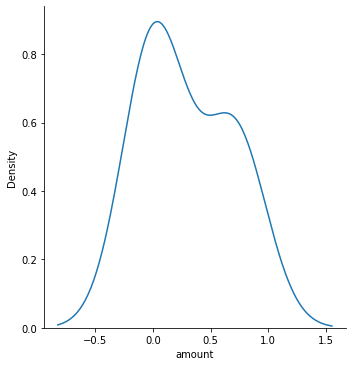

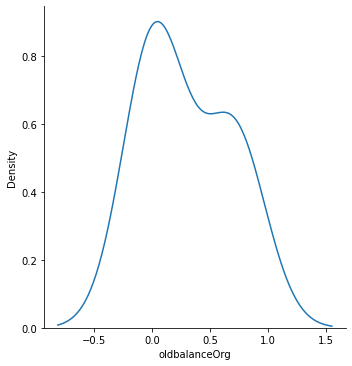

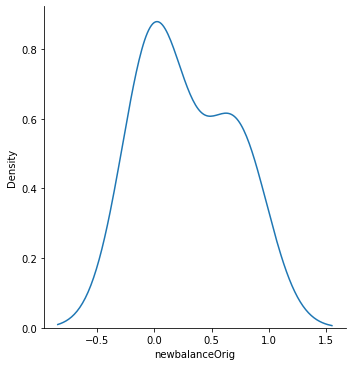

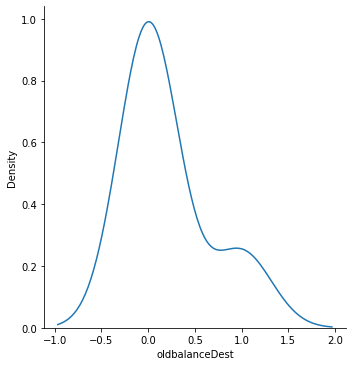

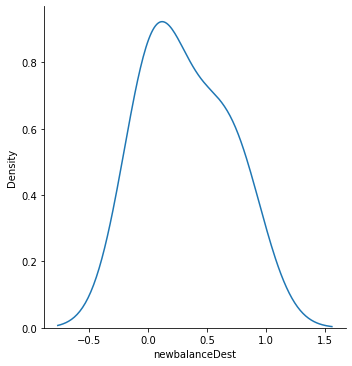

In [17]:
i = 0
columns = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
for column in columns:
  if i < len(columns):
    sns.displot(x = norm_num_data[i], kind = "kde");
    plt.xlabel(xlabel = columns[i])
    plt.show()
    i += 1

In [18]:
# Box-cox transformation, in Scikit-learn, the methos used is Yeo-Johnson method, paper can be found in Scikit-Learn docs.
pt = PowerTransformer(standardize = False)

In [19]:
bc_num_data = pt.fit_transform(num_data)

In [20]:
bc_num_data

array([[16.07735023, 14.94437566,  7.64103482,  0.        ,  0.        ],
       [11.82702501, 11.89877568,  6.77523202,  0.        ,  0.        ],
       [ 7.0642614 ,  5.70229776, -0.        ,  0.        ,  0.        ],
       ...,
       [42.65333822, 20.78532432, -0.        , 13.93320469, 28.07020687],
       [32.27725269, 17.45459622, -0.        ,  0.        ,  0.        ],
       [32.27725269, 17.45459622, -0.        , 21.61466058, 28.48948268]])

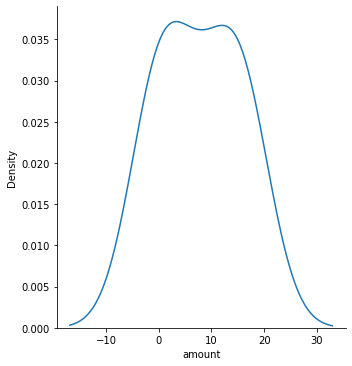

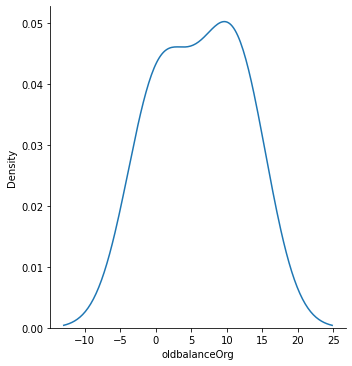

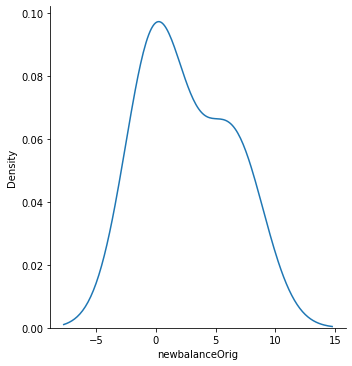

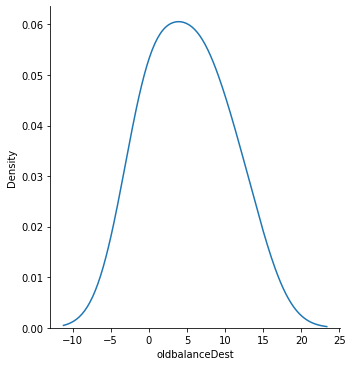

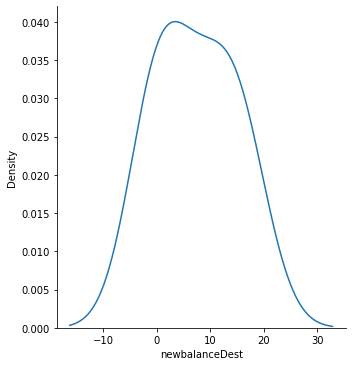

In [21]:
i = 0
columns = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
for column in columns:
  if i < len(columns):
    sns.displot(x = bc_num_data[i], kind = "kde");
    plt.xlabel(xlabel = columns[i])
    plt.show()
    i += 1

In [22]:
# Logarithm transformation
log_num_data = np.log(num_data)

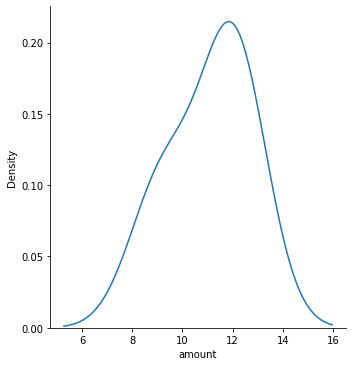

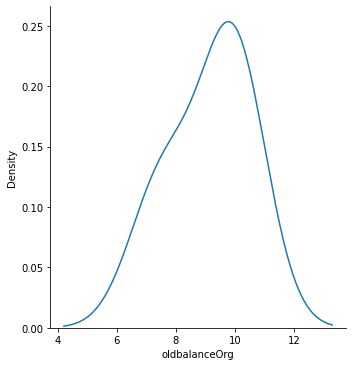

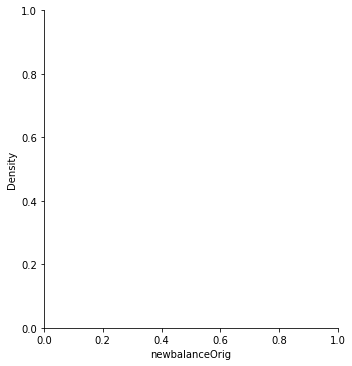

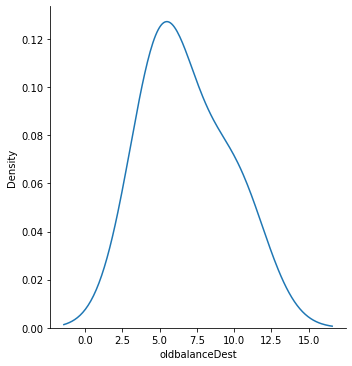

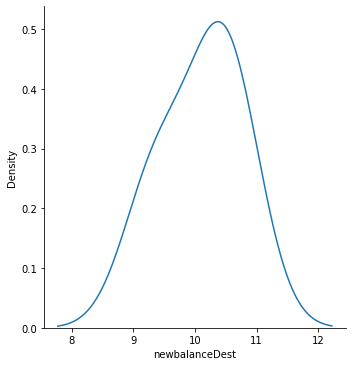

In [23]:
i = 0
columns = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
for column in columns:
  if i < len(columns):
    sns.displot(x = log_num_data[i], kind = "kde");
    plt.xlabel(xlabel = columns[i])
    plt.show()
    i += 1

In [24]:
for i in range(len(log_num_data)):
  print(log_num_data[i][2])

A saída de streaming foi truncada nas últimas 5000 linhas.
12.203317052368273
11.830426815445529
11.211718475103083
-inf
-inf
12.027055303800175
12.015792684479361
-inf
10.836899280128666
-inf
9.44283447034882
7.194797146546494
-inf
-inf
-inf
-inf
-inf
-inf
-inf
12.23412361253018
-inf
-inf
-inf
-inf
-inf
-inf
12.930131256806487
12.927891535952414
12.889073450271392
-inf
-inf
-inf
-inf
-inf
-inf
-inf
8.696889638957277
-inf
-inf
10.778195792451811
10.31615830419459
-inf
10.025578628579852
13.33226316799411
-inf
9.069586387690126
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
11.119606246009242
-inf
11.804591142321469
11.752596324791039
11.0258974192243
10.803470227982476
-inf
11.67775399029705
-inf
-inf
10.823942999930656
12.140256508588996
12.039743761481828
11.866419575417636
11.654363827454592
11.389909448622575
11.096939758937534
11.086525391713288
10.909271030256255
10.872962589709148
10.818375500969498
10.772451638774962
10.752676908631193
10.590259454122668
9.341057182377675
9.16026

KeyboardInterrupt: ignored